# Decision Boundaries on Toy Datasets

Objective:
Visualise how different classifiers carve decision boundaries
under identical data conditions.

Models covered:
- Logistic Regression
- k-NN
- SVM (RBF)
- Random Forest
- Gradient Boosting

This notebook is for *model intuition*.

## Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Toy datasets used

Each dataset stresses a different inductive bias.

- **Blobs**: roughly linearly separable
- **Moons**: smooth nonlinear boundary
- **Circles**: radial nonlinearity
- **XOR**: interaction-driven nonlinearity

These are two-dimensional (2D) for decision boundaries to be observable.

In [2]:
def make_xor(n_samples=800, noise=0.25, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.uniform(-1.5, 1.5, size=(n_samples, 2))
    y = (X[:, 0] * X[:, 1] < 0).astype(int)
    X += rng.normal(0.0, noise, size=X.shape)
    return X, y


def make_dataset(name, n_samples=800, noise=0.25, seed=42):
    name = name.lower()

    if name == "moons":
        return make_moons(n_samples=n_samples, noise=noise, random_state=seed)

    if name == "circles":
        return make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=seed)

    if name == "blobs":
        return make_blobs(n_samples=n_samples, centers=2, cluster_std=1.2, random_state=seed)

    if name == "xor":
        return make_xor(n_samples=n_samples, noise=noise, seed=seed)

    raise ValueError("Dataset must be moons, circles, blobs, or xor")

## Models and their assumptions

- Logistic Regression  
  Linear decision boundary in feature space.

- k-NN  
  Local similarity assumption. Boundary follows data density.

- SVM (RBF)  
  Smooth nonlinear boundary via kernel trick.

- Random Forest  
  Piecewise-constant regions from axis-aligned splits.

- Gradient Boosting  
  Sequential error-correcting trees. Higher bias control.

In [3]:
def get_models(seed=42):
    return {
        "Logistic Regression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=2000))
        ]),

        "k-NN": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(n_neighbors=25))
        ]),

        "SVM (RBF)": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(C=3.0, gamma="scale", probability=True))
        ]),

        "Random Forest": Pipeline([
            ("clf", RandomForestClassifier(
                n_estimators=400,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=seed
            ))
        ]),

        "Gradient Boosting": Pipeline([
            ("clf", GradientBoostingClassifier(random_state=seed))
        ]),
    }

## How decision boundaries are computed

1. Create a dense grid over feature space.
2. Predict probability for class 1 at each grid point.
3. Plot:
   - filled contours for probabilities
   - 0.5 contour as the decision boundary

This mirrors how classifiers *actually behave*,
not just training accuracy.

### Decision Surface Utility

In [6]:
def decision_surface(model, X, padding=0.6, grid_points=400):
    x_min, x_max = X[:, 0].min() - padding, X[:, 0].max() + padding
    y_min, y_max = X[:, 1].min() - padding, X[:, 1].max() + padding

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_points),
        np.linspace(y_min, y_max, grid_points),
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    if hasattr(model, "predict_proba"):
        zz = model.predict_proba(grid)[:, 1]
    else:
        scores = model.decision_function(grid)
        zz = 1 / (1 + np.exp(-scores))

    return xx, yy, zz.reshape(xx.shape)

### Plotting Function

In [7]:
def plot_boundaries(X_train, y_train, X_test, y_test, models, title):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for ax, (name, model) in zip(axes, models.items()):
        model.fit(X_train, y_train)

        xx, yy, zz = decision_surface(model, np.vstack([X_train, X_test]))

        ax.contourf(xx, yy, zz, levels=30, alpha=0.35)
        ax.contour(xx, yy, zz, levels=[0.5], linewidths=1.5)

        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=18, label="train")
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, marker="s", label="test")

        ax.set_title(f"{name}\nAcc={model.score(X_test, y_test):.3f}")
        ax.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Interactive controls

Change:
- dataset_name
- noise
- sample size

Observe:
- boundary smoothness
- overfitting
- bias vs variance behaviour

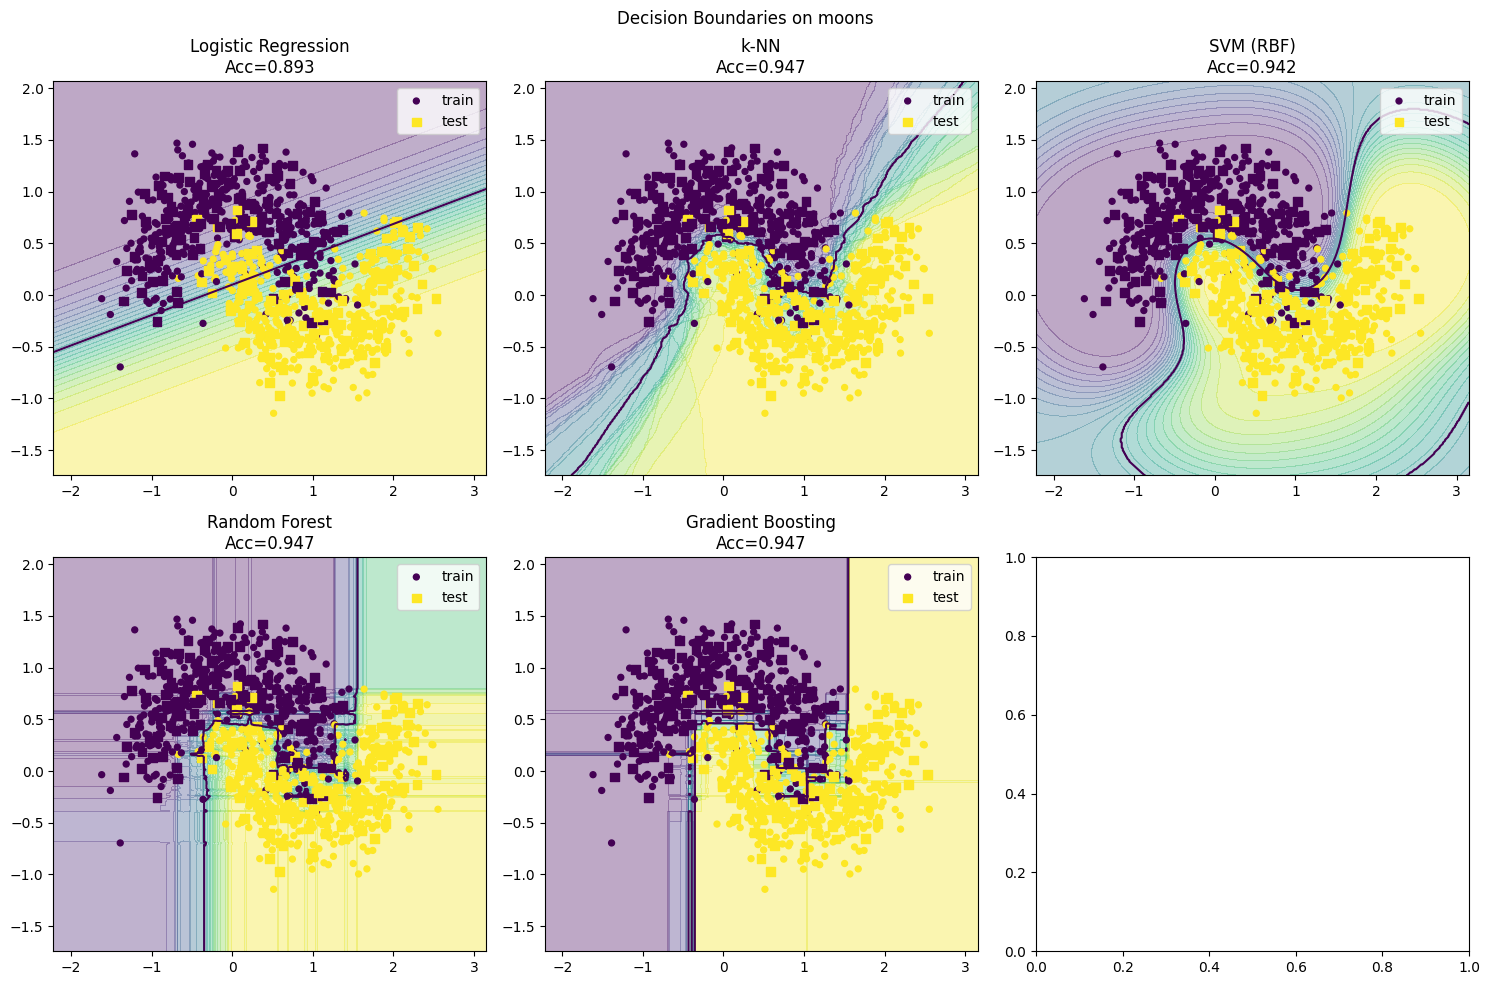

In [9]:
dataset_name = "moons"  # try: blobs, circles, xor
noise = 0.25

X, y = make_dataset(dataset_name, n_samples=900, noise=noise)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

models = get_models()
plot_boundaries(
    X_train, y_train,
    X_test, y_test,
    models,
    title=f"Decision Boundaries on {dataset_name}"
)

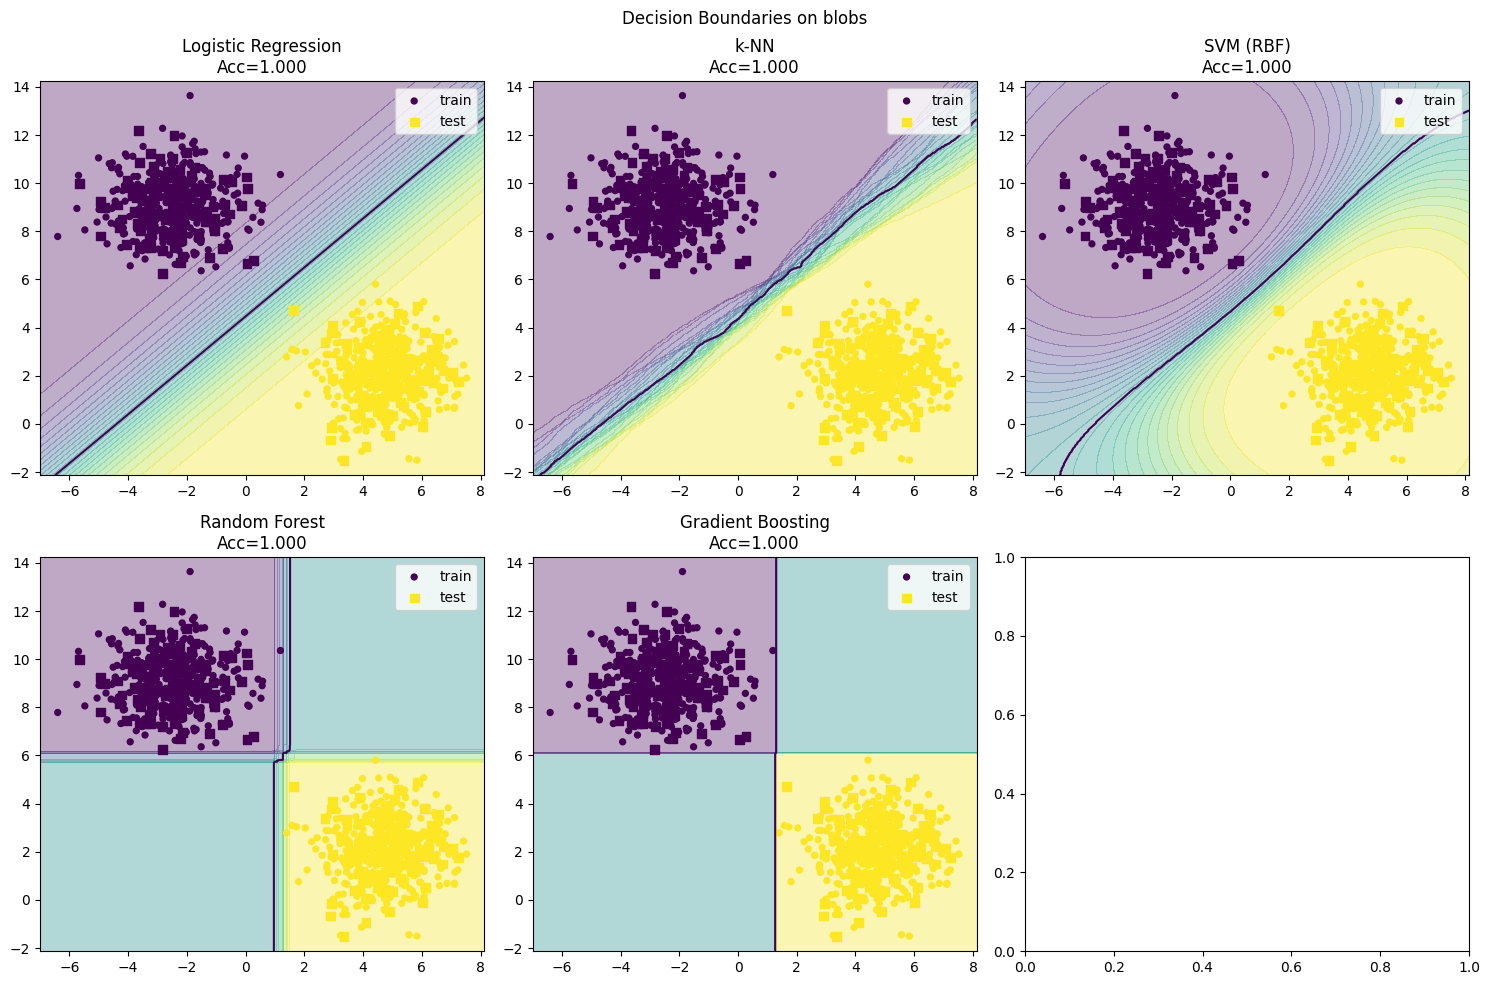

In [10]:
dataset_name = "blobs"  
noise = 0.25

X, y = make_dataset(dataset_name, n_samples=900, noise=noise)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

models = get_models()
plot_boundaries(
    X_train, y_train,
    X_test, y_test,
    models,
    title=f"Decision Boundaries on {dataset_name}"
)

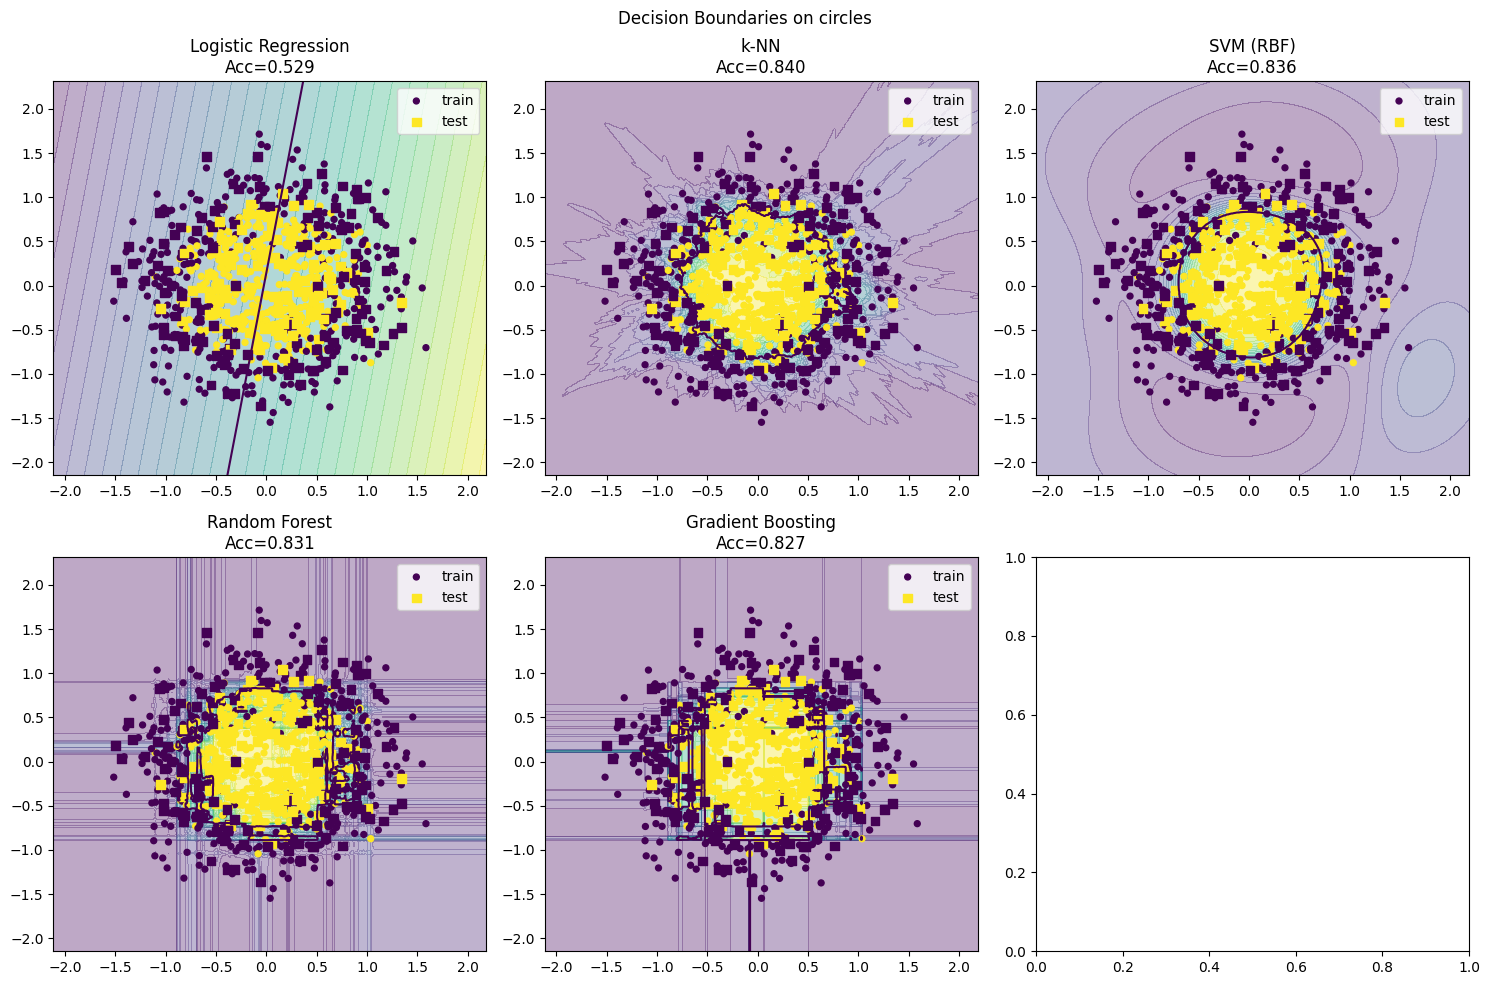

In [12]:
dataset_name = "circles"  
noise = 0.25

X, y = make_dataset(dataset_name, n_samples=900, noise=noise)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

models = get_models()
plot_boundaries(
    X_train, y_train,
    X_test, y_test,
    models,
    title=f"Decision Boundaries on {dataset_name}"
)

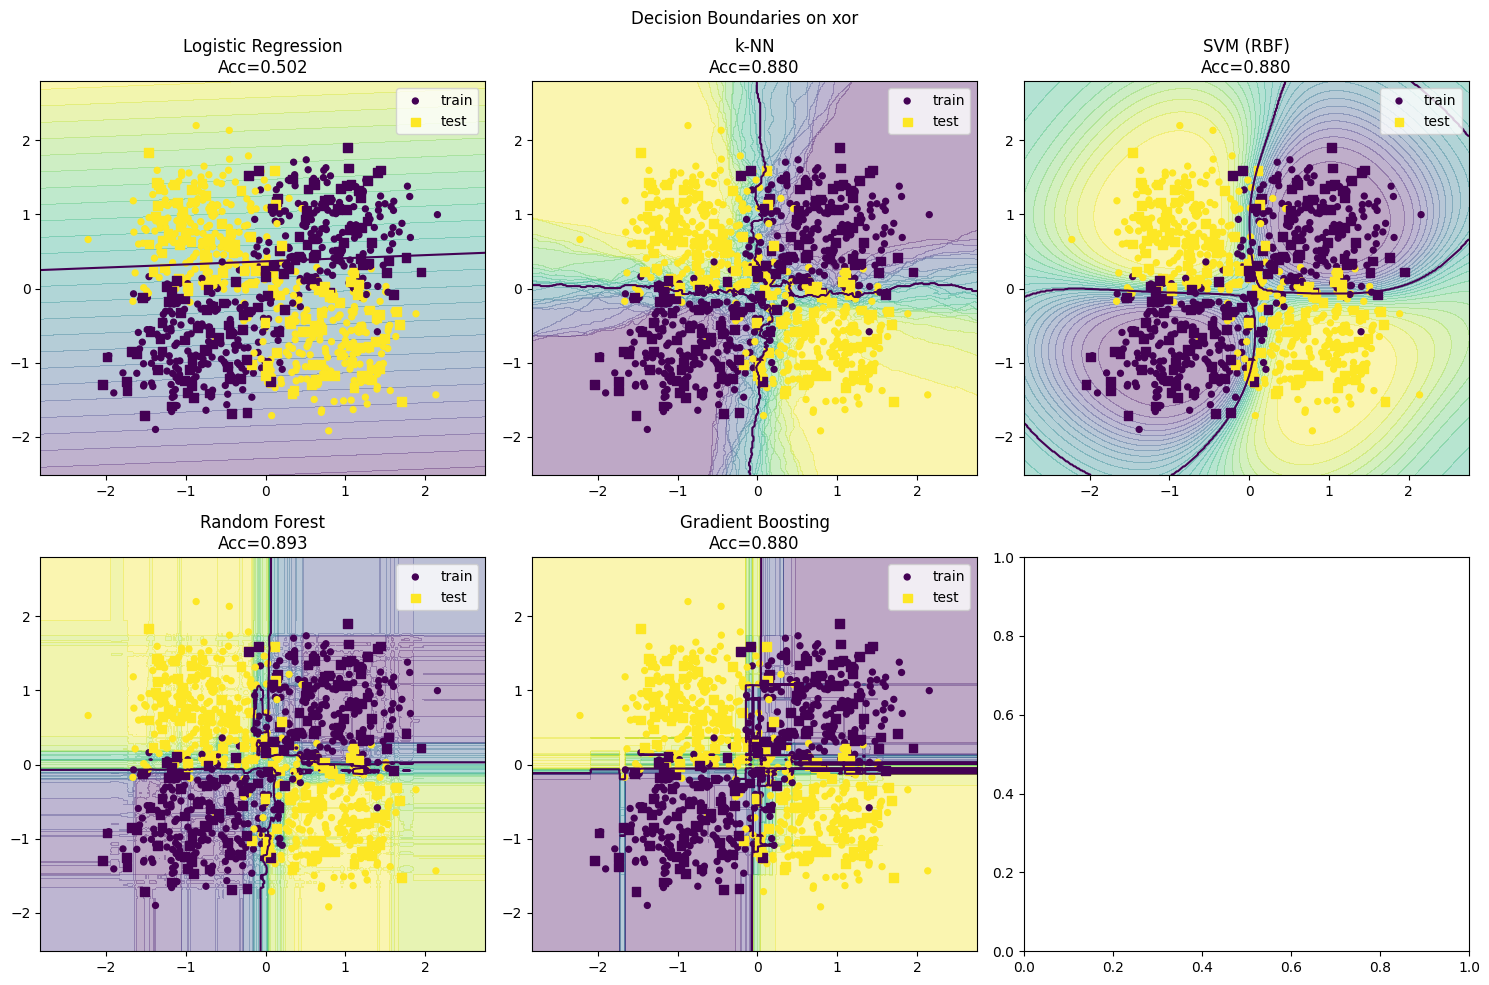

In [13]:
dataset_name = "xor"  
noise = 0.25

X, y = make_dataset(dataset_name, n_samples=900, noise=noise)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

models = get_models()
plot_boundaries(
    X_train, y_train,
    X_test, y_test,
    models,
    title=f"Decision Boundaries on {dataset_name}"
)